## Compute distance between ECPs

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
import src.purepyECP as pure
from src.bifiltration_utils import EC_at_bifiltration, plot_ECP, difference_ECP

## we want to compare circles vs figure 8s

In [3]:
def generate_circle(NUMBER_OF_POINTS, seed=42):
    point_cloud = []

    random.seed(seed)
    for i in range(NUMBER_OF_POINTS):
        angle = random.uniform(0,2*np.pi)
        point_cloud.append([np.cos(angle), np.sin(angle)])

    point_cloud = np.array(point_cloud)
    
    return point_cloud

In [4]:
def generate_figure8(NUMBER_OF_POINTS, seed=42):
    point_cloud = []

    random.seed(seed)
    for i in range(NUMBER_OF_POINTS//2):
        angle = random.uniform(0,2*np.pi)
        point_cloud.append([np.cos(angle), np.sin(angle)])
        # the second circle
        angle = random.uniform(0,2*np.pi)
        point_cloud.append([np.cos(angle)+2, np.sin(angle)])
        
    # add the last point
    if NUMBER_OF_POINTS%2 == 1:
        angle = random.uniform(0,2*np.pi)
        point_cloud.append([np.cos(angle), np.sin(angle)])

    point_cloud = np.array(point_cloud)
    
    return point_cloud

In [5]:
def generate_noisy_points(NUMBER_OF_POINTS, xmin=-1, xmax=1, ymin=-1, ymax=1, seed=42):
    point_cloud = []
    
    random.seed(seed)
    
    for i in range(NUMBER_OF_POINTS):
        point_cloud.append([random.uniform(xmin,xmax), 
                            random.uniform(ymin,ymax)])

    point_cloud = np.array(point_cloud)
    
    return point_cloud

## clean

20 20


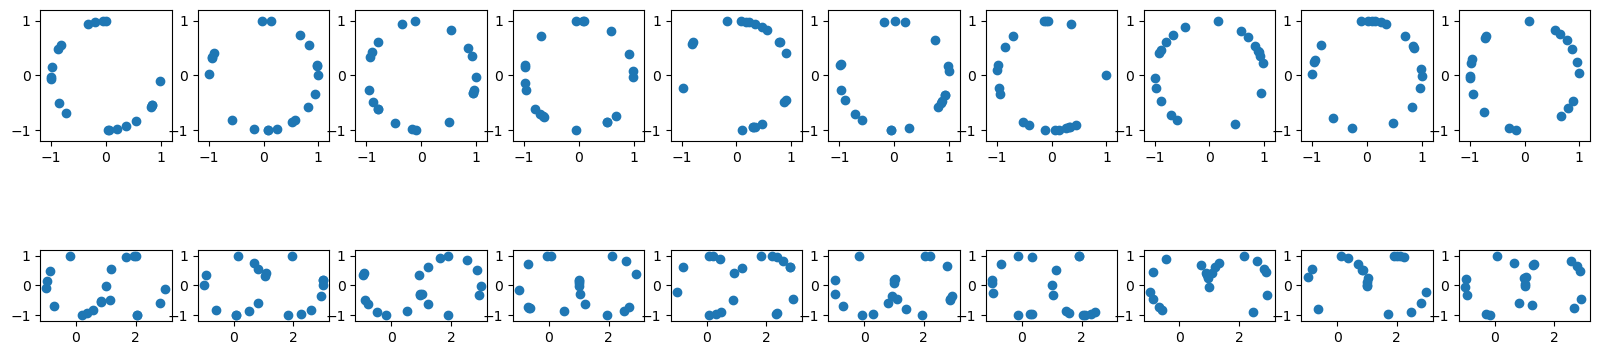

In [6]:
EPSILON = 10
NUMBER_OF_POINTS = 20
NUMBER_OF_SAMPLES = 10

list_of_ECP = []

list_of_pointclouds = [generate_circle(NUMBER_OF_POINTS, seed=i) for i in range(NUMBER_OF_SAMPLES)] + \
                      [generate_figure8(NUMBER_OF_POINTS, seed=i) for i in range(NUMBER_OF_SAMPLES)]

vertex_filtrations = [pure.gaussian_density(point_cloud, sigma=1) for point_cloud in list_of_pointclouds]

print(len(list_of_pointclouds), len(vertex_filtrations))

fig, axs = plt.subplots(2, NUMBER_OF_SAMPLES,
                       figsize=(20, 5))

for i in range(NUMBER_OF_SAMPLES):
    axs[0, i].scatter(list_of_pointclouds[i][:,0], list_of_pointclouds[i][:,1])
    axs[0, i].axis('scaled')
    axs[0, i].set_xlim((-1.2,1.2))
    axs[0, i].set_ylim((-1.2,1.2))
    
for i in range(NUMBER_OF_SAMPLES):
    axs[1, i].scatter(list_of_pointclouds[i+NUMBER_OF_SAMPLES][:,0], 
                      list_of_pointclouds[i+NUMBER_OF_SAMPLES][:,1])
    axs[1, i].axis('scaled')
    axs[1, i].set_xlim((-1.2,3.2))
    axs[1, i].set_ylim((-1.2,1.2))

In [ ]:
for i, pointcloud in tqdm(enumerate(list_of_pointclouds)):
    
    contributions, num_simplices = pure.compute_local_contributions(pointcloud, EPSILON, vertex_filtrations[i])
    list_of_ECP.append(contributions)

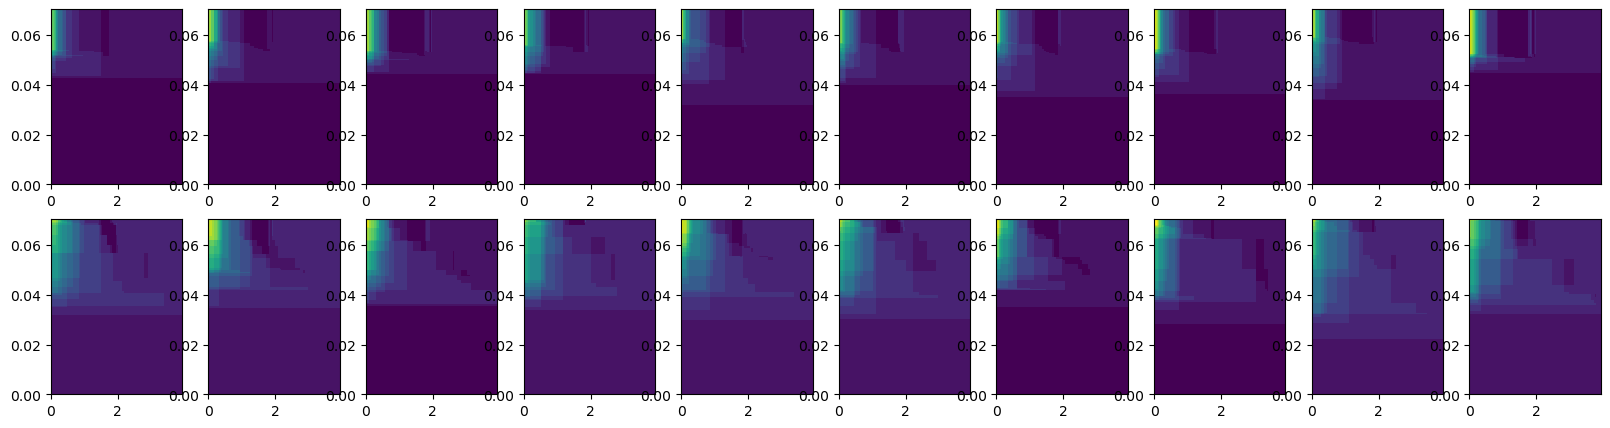

In [8]:
f1max = max( [max([c[0][0] for c in contributions]) for contributions in list_of_ECP] )
f2max = max( [max([c[0][1] for c in contributions]) for contributions in list_of_ECP] )

fig, axs = plt.subplots(2, NUMBER_OF_SAMPLES,
                       figsize=(20, 5))

for i in range(NUMBER_OF_SAMPLES):
    plot_ECP(list_of_ECP[i], (0, f1max, 0, f2max), axs[0,i])
    
for i in range(NUMBER_OF_SAMPLES):
    plot_ECP(list_of_ECP[i+NUMBER_OF_SAMPLES], (0, f1max, 0, f2max), axs[1,i])

In [9]:
distance_matrix = np.zeros((NUMBER_OF_SAMPLES*2, NUMBER_OF_SAMPLES*2))

for i in range(len(list_of_ECP)):
    for j in range(i+1, len(list_of_ECP)):
        distance_matrix[i,j] = difference_ECP(list_of_ECP[i], list_of_ECP[j], (0, f1max, 0, f2max))
        distance_matrix[j,i] = difference_ECP(list_of_ECP[j], list_of_ECP[i], (0, f1max, 0, f2max))

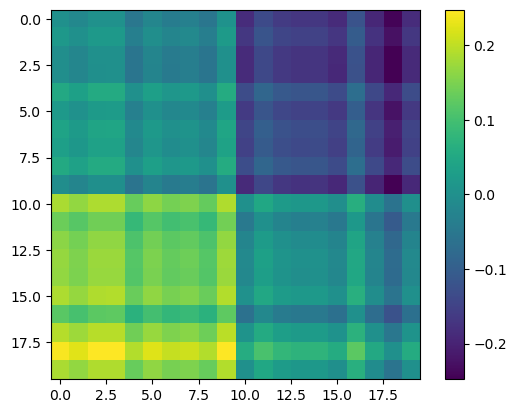

In [10]:
plt.imshow(distance_matrix)
plt.colorbar()

## noisy

In [11]:
EPSILON = 10
NUMBER_OF_POINTS = 20
NUMBER_OF_SAMPLES = 10

list_of_noisy_pointclouds = [generate_circle(NUMBER_OF_POINTS, seed=i) for i in range(NUMBER_OF_SAMPLES)] + \
                      [generate_figure8(NUMBER_OF_POINTS, seed=i) for i in range(NUMBER_OF_SAMPLES)]

# add points in the centre
EXTRA_POINTS = 2
if EXTRA_POINTS%2 != 0:
    raise(ValueError("Please choose an even number"))

#cirles
for i in range(NUMBER_OF_SAMPLES):
    list_of_noisy_pointclouds[i] = np.concatenate((list_of_noisy_pointclouds[i], 
                                            generate_noisy_points(EXTRA_POINTS, 
                                                                  -0.5, 0.5, -0.5, 0.5)))
# figure 8   
for i in range(NUMBER_OF_SAMPLES, NUMBER_OF_SAMPLES*2):
    list_of_noisy_pointclouds[i] = np.concatenate((list_of_noisy_pointclouds[i], 
                                            generate_noisy_points(EXTRA_POINTS//2, 
                                                                  -0.5, 0.5, -0.5, 0.5)))
    
    list_of_noisy_pointclouds[i] = np.concatenate((list_of_noisy_pointclouds[i], 
                                            generate_noisy_points(EXTRA_POINTS//2, 
                                                                  1.5, 2.5, -0.5, 0.5)))
    
noisy_vertex_filtrations = [pure.gaussian_density(point_cloud, sigma=1) for point_cloud in list_of_noisy_pointclouds]

print(len(list_of_noisy_pointclouds), len(noisy_vertex_filtrations))

20 20


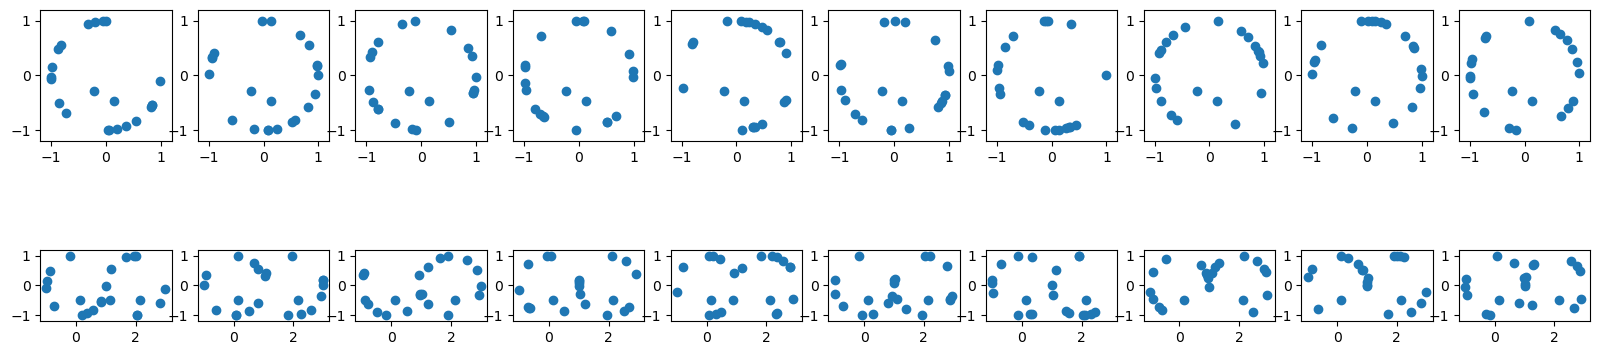

In [12]:
fig, axs = plt.subplots(2, NUMBER_OF_SAMPLES,
                       figsize=(20, 5))

for i in range(NUMBER_OF_SAMPLES):
    axs[0, i].scatter(list_of_noisy_pointclouds[i][:,0], list_of_noisy_pointclouds[i][:,1])
    axs[0, i].axis('scaled')
    axs[0, i].set_xlim((-1.2,1.2))
    axs[0, i].set_ylim((-1.2,1.2))
    
for i in range(NUMBER_OF_SAMPLES):
    axs[1, i].scatter(list_of_noisy_pointclouds[i+NUMBER_OF_SAMPLES][:,0], 
                      list_of_noisy_pointclouds[i+NUMBER_OF_SAMPLES][:,1])
    axs[1, i].axis('scaled')
    axs[1, i].set_xlim((-1.2,3.2))
    axs[1, i].set_ylim((-1.2,1.2))

In [ ]:
noisy_list_of_ECP = []

for i, pointcloud in tqdm(enumerate(list_of_noisy_pointclouds)):
    
    contributions, num_simplices = pure.compute_local_contributions(pointcloud, EPSILON, 
                                                                    noisy_vertex_filtrations[i])

    noisy_list_of_ECP.append(contributions)

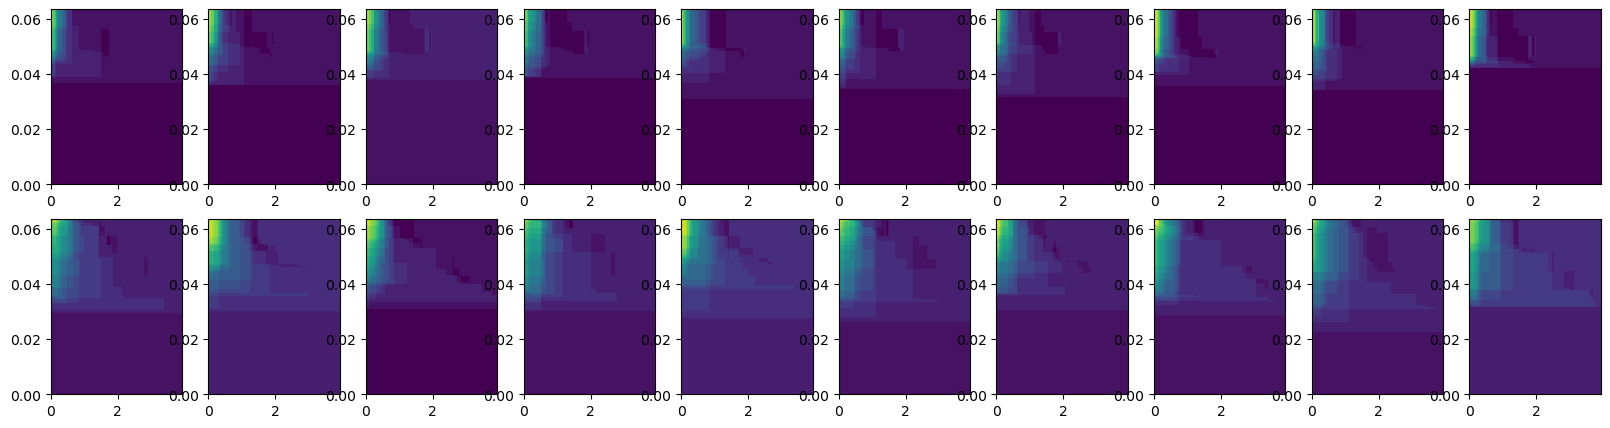

In [14]:
f1max = max( [max([c[0][0] for c in contributions]) for contributions in noisy_list_of_ECP] )
f2max = max( [max([c[0][1] for c in contributions]) for contributions in noisy_list_of_ECP] )

fig, axs = plt.subplots(2, NUMBER_OF_SAMPLES,
                       figsize=(20, 5))

for i in range(NUMBER_OF_SAMPLES):
    plot_ECP(noisy_list_of_ECP[i], (0, f1max, 0, f2max), axs[0,i])
    
for i in range(NUMBER_OF_SAMPLES):
    plot_ECP(noisy_list_of_ECP[i+NUMBER_OF_SAMPLES], (0, f1max, 0, f2max), axs[1,i])

In [15]:
noisy_distance_matrix = np.zeros((NUMBER_OF_SAMPLES*2, NUMBER_OF_SAMPLES*2))

for i in range(len(noisy_list_of_ECP)):
    for j in range(i+1, len(noisy_list_of_ECP)):
        noisy_distance_matrix[i,j] = difference_ECP(noisy_list_of_ECP[i], noisy_list_of_ECP[j], 
                                                    (0, f1max, 0, f2max))
        noisy_distance_matrix[j,i] = difference_ECP(noisy_list_of_ECP[j], noisy_list_of_ECP[i], 
                                                    (0, f1max, 0, f2max))

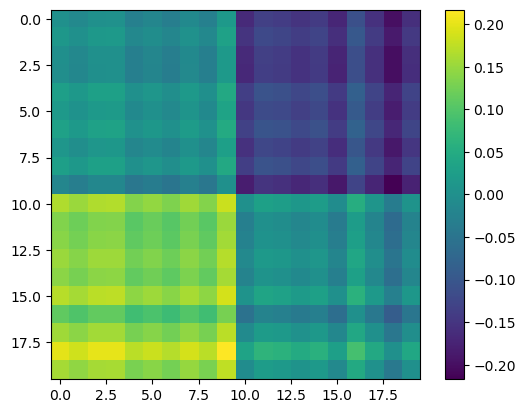

In [16]:
plt.imshow(noisy_distance_matrix)
plt.colorbar()

## Comparison

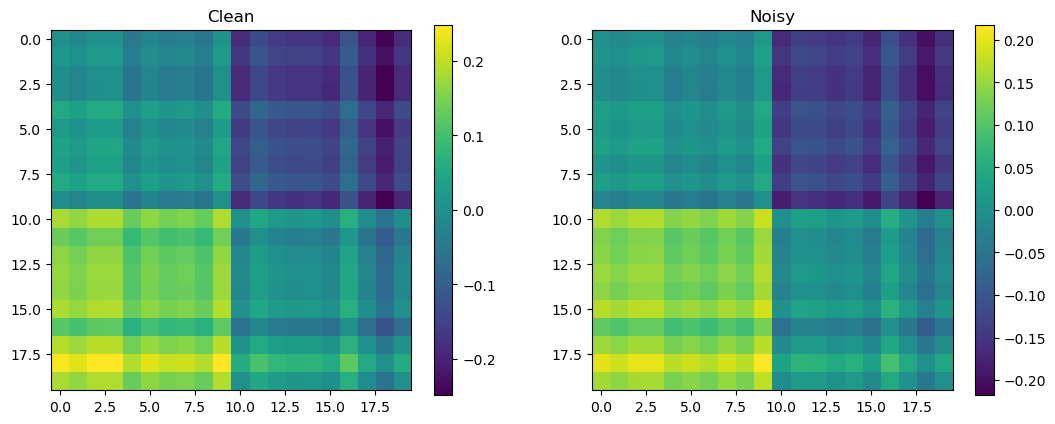

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

im0 = axs[0].imshow(distance_matrix)
plt.colorbar(im0, ax=axs[0])
axs[0].set_title('Clean')

im1 = axs[1].imshow(noisy_distance_matrix)
plt.colorbar(im1, ax=axs[1])
axs[1].set_title('Noisy')

plt.show()